# Default Risk and Income Fluctuations

```{include} _admonition/gpu.md
```

In addition to what's in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install quantecon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/214.8 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.8/214.8 kB 8.0 MB/s eta 0:00:00


## Overview

This lecture computes versions of Arellano’s {cite}`Are08` model of sovereign default.

The model describes interactions among default risk, output, and an
equilibrium interest rate that includes a premium for endogenous default risk.

The decision maker is a government of a small open economy that borrows from
risk-neutral foreign creditors.

The foreign lenders must be compensated for default risk.

The government borrows and lends abroad in order to smooth the consumption of
its citizens.

The government repays its debt only if it wants to, but declining to pay has
adverse consequences.

The interest rate on government debt adjusts in response to the
state-dependent default probability chosen by government.

The model yields outcomes that help interpret sovereign default experiences,
including

- countercyclical interest rates on sovereign debt
- countercyclical trade balances
- high volatility of consumption relative to output


Notably, long recessions caused by bad draws in the income process increase the government’s
incentive to default.

This can lead to

- spikes in interest rates
- temporary losses of access to international credit markets
- large drops in output, consumption, and welfare
- large capital outflows during recessions


Such dynamics are consistent with experiences of many countries.

Let’s start with some imports:

In [2]:
import matplotlib.pyplot as plt
import quantecon as qe
import random

import jax
import jax.numpy as jnp

Let's check the GPU we are running

In [3]:
!nvidia-smi

Tue May 16 11:07:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 12.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|


|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   30C    P0    38W / 300W |      0MiB / 16160MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+


We will use 64 bit floats with JAX in order to increase the precision.

In [4]:
jax.config.update("jax_enable_x64", True)

## Structure

In this section we describe the main features of the model.

### Output, Consumption and Debt

A small open economy is endowed with an exogenous stochastically fluctuating potential output
stream $ \{y_t\} $.

Potential output is realized only in periods in which the government honors its sovereign debt.

The output good can be traded or consumed.

The sequence $ \{y_t\} $ is described by a Markov process with stochastic density kernel
$ p(y, y') $.

Households within the country are identical and rank stochastic consumption streams according to

$$
 \mathbb E \sum_{t=0}^{\infty} \beta^t u(c_t)
 $$ (equation13_1)

Here

- $ 0 < \beta < 1 $ is a time discount factor
- $ u $ is an increasing and strictly concave utility function


Consumption sequences enjoyed by households are affected by the government’s decision to borrow or
lend internationally.

The government is benevolent in the sense that its aim is to maximize {eq}`equation13_1`.

The government is the only domestic actor with access to foreign credit.

Because households are averse to consumption fluctuations, the government will try to smooth
consumption by borrowing from (and lending to) foreign creditors.

### Asset Markets

The only credit instrument available to the government is a one-period bond traded in international credit markets.

The bond market has the following features

- The bond matures in one period and is not state contingent.
- A purchase of a bond with face value $ B' $ is a claim to $ B' $ units of the
  consumption good next period.
- To purchase $ B' $  next period costs $ q B' $ now, or, what is equivalent.
- For selling $ -B' $ units of next period goods the seller earns $ - q B' $ of today’s
  goods.
  - If $ B' < 0 $, then $ -q B' $ units of the good are received in the current period,
    for a promise to repay $ -B' $ units next period.
  - There is an equilibrium  price function $ q(B', y) $ that makes $ q $ depend on both
    $ B' $ and $ y $.


Earnings on the government portfolio are distributed (or, if negative, taxed) lump sum to
households.

When the government is not excluded from financial markets, the one-period national budget
constraint is

$$
c = y + B - q(B', y) B'
$$ (equation13_2)

Here and below, a prime denotes a next period value or a claim maturing next period.

To rule out Ponzi schemes, we also require that $ B \geq -Z $ in every period.

- $ Z $ is chosen to be sufficiently large that the constraint never binds in equilibrium.

### Financial Markets

Foreign creditors

- are risk neutral
- know the domestic output stochastic process $ \{y_t\} $ and observe
  $ y_t, y_{t-1}, \ldots, $ at time $ t $
- can borrow or lend without limit in an international credit market at a constant international
  interest rate $ r $
- receive full payment if the government chooses to pay
- receive zero if the government defaults on its one-period debt due


When a government is expected to default next period with probability $ \delta $, the expected
value of a promise to pay one unit of consumption next period is $ 1 - \delta $.

Therefore, the discounted expected value of a promise to pay $ B $ next period is

$$
q = \frac{1 - \delta}{1 + r}
$$ (equation13_3)

Next we turn to how the government in effect chooses the default probability $ \delta $.

### Government’s Decisions

At each point in time $ t $, the government chooses between

1. defaulting
1. meeting its current obligations and purchasing or selling an optimal quantity of  one-period
  sovereign debt


Defaulting means declining to repay all of its current obligations.

If the government defaults in the current period, then consumption equals current output.

But a sovereign default has two consequences:

1. Output immediately falls from $ y $ to $ h(y) $, where $ 0 \leq h(y) \leq y $.
  - It returns to $ y $ only after the country regains access to international credit
    markets.
1. The country loses access to foreign credit markets.

### Reentering International Credit Market

While in a state of default, the economy regains access to foreign credit in each subsequent
period with probability $ \theta $.

## Equilibrium

Informally, an equilibrium is a sequence of interest rates on its sovereign debt, a stochastic
sequence of government default decisions and an implied flow of household consumption such that

1. Consumption and assets satisfy the national budget constraint.
1. The government maximizes household utility taking into account
  - the resource constraint
  - the effect of its choices on the price of bonds
  - consequences of defaulting now for future net output and future borrowing and lending
    opportunities
1. The interest rate on the government’s debt includes a risk-premium sufficient to make foreign
  creditors expect on average to earn the constant risk-free international interest rate.


To express these ideas more precisely, consider first the choices of the government, which

1. enters a period with initial assets $ B $, or what is the same thing, initial debt to be
  repaid now of $ -B $
1. observes current output $ y $, and
1. chooses either
  1. to default, or
  1. to pay $ -B $ and set next period’s debt due to $ -B' $


In a recursive formulation,

- state variables for the government comprise the pair $ (B, y) $
- $ v(B, y) $ is the optimum value of the government’s problem when at the beginning of a
  period it faces the choice of whether to honor or default
- $ v_c(B, y) $ is the value of choosing to pay obligations falling due
- $ v_d(y) $ is the value of choosing to default


$ v_d(y) $ does not depend on $ B $ because, when access to credit is eventually regained,
net foreign assets equal $ 0 $.

Expressed recursively, the value of defaulting is

$$
v_d(y) = u(h(y)) +
            \beta \int \left\{
            \theta v(0, y') + (1 - \theta) v_d(y')
            \right\}
            p(y, y') dy'
$$

The value of paying is

$$
v_c(B, y) = \max_{B' \geq -Z}
       \left\{
            u(y - q(B', y) B' + B) +
            \beta \int v(B', y') p(y, y') dy'
      \right\}
$$

The three value functions are linked by

$$
v(B, y) = \max\{ v_c(B, y), v_d(y) \}
$$

The government chooses to default when

$$
v_c(B, y) < v_d(y)
$$

and hence given $ B' $ the probability of default next period is

$$
\delta(B', y) := \int \mathbb 1\{v_c(B', y') < v_d(y') \} p(y, y') dy'
$$ (equation13_4)

Given zero profits for foreign creditors in equilibrium, we can combine {eq}`equation13_3` and {eq}`equation13_4`
to pin down the bond price function:

$$
q(B', y) = \frac{1 - \delta(B', y)}{1 + r}
$$ (equation13_5)

### Definition of Equilibrium

An *equilibrium* is

- a pricing function $ q(B',y) $,
- a triple of value functions $ (v_c(B, y), v_d(y), v(B,y)) $,
- a decision rule telling the government when to default and when to pay as a function of the state
  $ (B, y) $, and
- an asset accumulation rule that, conditional on choosing not to default, maps $ (B,y) $ into
  $ B' $


such that

- The three Bellman equations for $ (v_c(B, y), v_d(y), v(B,y)) $ are satisfied
- Given the price function $ q(B',y) $, the default decision rule and the asset accumulation
  decision rule attain the optimal value function  $ v(B,y) $, and
- The price function $ q(B',y) $ satisfies equation {eq}`equation13_5`

## Computation

Let’s now compute an equilibrium of Arellano’s model.

The equilibrium objects are the value function $ v(B, y) $, the associated
default decision rule, and the pricing function $ q(B', y) $.

We’ll use our code to replicate Arellano’s results.

After that we’ll perform some additional simulations.

We use a slightly modified version of the algorithm recommended by Arellano.

- The appendix to {cite}`Are08` recommends value function iteration until
  convergence, updating the price, and then repeating.
- Instead, we update the bond price at every value function iteration step.


The second approach is faster and the two different procedures deliver very similar results.

Here is a more detailed description of our algorithm:

1. Guess a pair of non-default and default value functions $ v_c $ and $ v_d $.
1. Using these functions, calculate the value function $ v $, the corresponding default probabilities and the price function $ q $.
1. At each pair $ (B, y) $,
  1. update the value of defaulting $ v_d(y) $.
  1. update the value of remaining $ v_c(B, y) $.
1. Check for convergence. If converged, stop – if not, go to step 2.


We use simple discretization on a grid of asset holdings and income levels.

The output process is discretized using a [quadrature method due to Tauchen](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/markov/approximation.py).

As we have in other places, we accelerate our code using Numba.

We define a class that will store parameters, grids and transition
probabilities.

In [5]:
class Arellano_Economy:
    " Stores data and creates primitives for the Arellano economy. "

    def __init__(self,
            B_grid_size=251,   # Grid size for bonds
            B_grid_min=-0.45,   # Smallest B value
            B_grid_max=0.45,    # Largest B value
            y_grid_size=51,     # Grid size for income
            β=0.953,            # Time discount parameter
            γ=2.0,              # Utility parameter
            r=0.017,            # Lending rate
            ρ=0.945,            # Persistence in the income process
            η=0.025,            # Standard deviation of the income process
            θ=0.282,            # Prob of re-entering financial markets
            def_y_param=0.969): # Parameter governing income in default

        # Save parameters
        self.β, self.γ, self.r, = β, γ, r
        self.ρ, self.η, self.θ = ρ, η, θ

        # Set up grids
        self.y_grid_size = y_grid_size
        self.B_grid_size = B_grid_size
        B_grid = jnp.linspace(B_grid_min, B_grid_max, B_grid_size)
        mc = qe.markov.tauchen(y_grid_size, ρ, η)
        y_grid, P = jnp.exp(mc.state_values), mc.P

        # Put grids on the device
        self.B_grid = jax.device_put(B_grid)
        self.y_grid = jax.device_put(y_grid)
        self.P = jax.device_put(P)

        # Output recieved while in default, with same shape as y_grid
        self.def_y = jnp.minimum(def_y_param * jnp.mean(self.y_grid), self.y_grid)

    def params(self):
        return self.β, self.γ, self.r, self.ρ, self.η, self.θ

    def sizes(self):
        return self.B_grid_size, self.y_grid_size

    def arrays(self):
        return self.P, self.B_grid, self.y_grid, self.def_y

Here is the utility function.

In [6]:
@jax.jit
def u(c, γ):
    return c**(1-γ)/(1-γ)

Here is a function to compute the bond price at each state, given $ v_c $ and
$ v_d $.

In [7]:
def compute_q(v_c, v_d, params, sizes, arrays):
    """
    Compute the bond price function q(B, y) at each (B, y) pair.  The first
    step is to calculate the default probabilities

        δ(B, y) := Σ_{y'} 1{v_c(B, y') < v_d(y')} P(y, y') dy'

    """

    # Unpack
    β, γ, r, ρ, η, θ = params
    B_size, y_size = sizes
    P, B_grid, y_grid, def_y = arrays

    # Set up arrays with indices [i_B, i_y, i_yp]
    v_d = jnp.reshape(v_d, (1, 1, y_size))
    v_c = jnp.reshape(v_c, (B_size, 1, y_size))
    P = jnp.reshape(P, (1, y_size, y_size))

    # Compute δ[i_B, i_y]
    default_states = v_c < v_d
    delta = jnp.sum(default_states * P, axis=(2,))

    q = (1 - delta ) / (1 + r)
    return q

Next we introduce Bellman operators that updated $ v_d $ and $ v_c $.

In [8]:
def T_d(v_c, v_d, params, sizes, arrays):
    """
    The RHS of the Bellman equation when income is at index y_idx and
    the country has chosen to default.  Returns an update of v_d.
    """
    # Unpack
    β, γ, r, ρ, η, θ = params
    B_size, y_size = sizes
    P, B_grid, y_grid, def_y = arrays
    B0_idx = jnp.searchsorted(B_grid, 1e-10)  # Index at which B is near zero

    current_utility = u(def_y, γ)
    v = jnp.maximum(v_c[B0_idx, :], v_d)
    w = θ * v + (1 - θ) * v_d
    A = jnp.reshape(w, (1, y_size))
    cont_value = jnp.sum(A * P, axis=(1,))

    return current_utility + β * cont_value

In [9]:
def bellman(v_c, v_d, q, params, sizes, arrays):
    """
    The RHS of the Bellman equation when the country is not in a
    defaulted state on their debt.  That is,

        bellman(B, y) =
            u(y - q(B', y) B' + B) + β Σ_{y'} v(B', y') P(y, y')

    If consumption is not positive then returns -np.inf
    """
    # Unpack
    β, γ, r, ρ, η, θ = params
    B_size, y_size = sizes
    P, B_grid, y_grid, def_y = arrays

    # Set up c[i_B, i_y, i_Bp]
    y_idx = jnp.reshape(jnp.arange(y_size), (1, y_size, 1))
    B_idx = jnp.reshape(jnp.arange(B_size), (B_size, 1, 1))
    Bp_idx = jnp.reshape(jnp.arange(B_size), (1, 1, B_size))
    c = y_grid[y_idx] - q[Bp_idx, y_idx] * B_grid[Bp_idx] + B_grid[B_idx]

    # Set up v[i_B, i_y, i_Bp, i_yp] and P[i_B, i_y, i_Bp, i_yp]
    v_d = jnp.reshape(v_d, (1, 1, 1, y_size))
    v_c = jnp.reshape(v_c, (1, 1, B_size, y_size))
    v = jnp.maximum(v_c, v_d)
    P = jnp.reshape(P, (1, y_size, 1, y_size))
    # Sum over i_yp
    continuation_value = jnp.sum(v * P, axis=(3,))

    # Return new_v_c[i_B, i_y, i_Bp]
    val = jnp.where(c > 0, u(c, γ) + β * continuation_value, -jnp.inf)
    return val

In [10]:
def T_c(v_c, v_d, q, params, sizes, arrays):
    vals = bellman(v_c, v_d, q, params, sizes, arrays)
    return jnp.max(vals, axis=2)

In [11]:
def get_greedy(v_c, v_d, q, params, sizes, arrays):
    vals = bellman(v_c, v_d, q, params, sizes, arrays)
    return jnp.argmax(vals, axis=2)

Let's make JIT-compiled versions of these functions, with the sizes of the arrays declared as static (compile-time constants) in order to help the compiler.

In [12]:
compute_q = jax.jit(compute_q, static_argnums=(3,))
T_d = jax.jit(T_d, static_argnums=(3,))
bellman = jax.jit(bellman, static_argnums=(4,))
T_c = jax.jit(T_c, static_argnums=(4,))
get_greedy = jax.jit(get_greedy, static_argnums=(4,))

Here is a function that calls these operators in the right sequence.

In [13]:
def update_values_and_prices(v_c, v_d, params, sizes, arrays):

    q = compute_q(v_c, v_d, params, sizes, arrays)
    new_v_d = T_d(v_c, v_d, params, sizes, arrays)
    new_v_c = T_c(v_c, v_d, q, params, sizes, arrays)

    return new_v_c, new_v_d

We can now write a function that will use the `Arellano_Economy` class and the
functions defined above to compute the solution to our model.

One of the jobs of this function is to take an instance of
`Arellano_Economy`, which is hard for the JIT compiler to handle, and strip it
down to more basic objects, which are then passed out to jitted functions.

In [14]:
def solve(model, tol=1e-8, max_iter=10_000):
    """
    Given an instance of Arellano_Economy, this function computes the optimal
    policy and value functions.
    """
    # Unpack
    params = model.params()
    sizes = model.sizes()
    arrays = model.arrays()
    B_size, y_size = sizes

    # Initial conditions for v_c and v_d
    v_c = jnp.zeros((B_size, y_size))
    v_d = jnp.zeros((y_size,))

    current_iter = 0
    error = tol + 1
    while (current_iter < max_iter) and (error > tol):
        if current_iter % 100 == 0:
            print(f"Entering iteration {current_iter} with error {error}.")
        new_v_c, new_v_d = update_values_and_prices(v_c, v_d, params, sizes, arrays)
        error = jnp.max(jnp.abs(new_v_c - v_c)) + jnp.max(jnp.abs(new_v_d - v_d))
        v_c, v_d = new_v_c, new_v_d
        current_iter += 1

    print(f"Terminating at iteration {current_iter}.")

    q = compute_q(v_c, v_d, params, sizes, arrays)
    B_star = get_greedy(v_c, v_d, q, params, sizes, arrays)
    return v_c, v_d, q, B_star

Let's try solving the model.

In [15]:
ae = Arellano_Economy()

In [16]:
v_c, v_d, q, B_star = solve(ae)

Entering iteration 0 with error 1.00000001.


Entering iteration 100 with error 0.017499341639204857.
Entering iteration 200 with error 0.00014189363558969603.


Entering iteration 300 with error 1.151467966309383e-06.
Terminating at iteration 399.


In [17]:
%%time
v_c, v_d, q, B_star = solve(ae)

Entering iteration 0 with error 1.00000001.
Entering iteration 100 with error 0.017499341639204857.


Entering iteration 200 with error 0.00014189363558969603.
Entering iteration 300 with error 1.151467966309383e-06.


Terminating at iteration 399.
CPU times: user 1.17 s, sys: 258 ms, total: 1.43 s
Wall time: 572 ms


Finally, we write a function that will allow us to simulate the economy once
we have the policy functions

In [18]:
def simulate(model, T, v_c, v_d, q, B_star, key):
    """
    Simulates the Arellano 2008 model of sovereign debt

    Here `model` is an instance of `Arellano_Economy` and `T` is the length of
    the simulation.  Endogenous objects `v_c`, `v_d`, `q` and `B_star` are
    assumed to come from a solution to `model`.

    """
    # Unpack elements of the model
    B_size, y_size = model.sizes()
    B_grid, y_grid, P = model.B_grid, model.y_grid, model.P
    B0_idx = jnp.searchsorted(B_grid, 1e-10)  # Index at which B is near zero

    # Set initial conditions
    y_idx = y_size // 2
    B_idx = B0_idx
    in_default = False

    # Create Markov chain and simulate income process
    mc = qe.MarkovChain(P, y_grid)
    y_sim_indices = mc.simulate_indices(T+1, init=y_idx)

    # Allocate memory for outputs
    y_sim = jnp.empty(T)
    y_a_sim = jnp.empty(T)
    B_sim = jnp.empty(T)
    q_sim = jnp.empty(T)
    d_sim = jnp.empty(T, dtype=int)

    # Perform simulation
    t = 0
    while t < T:

        # Update y_sim and B_sim
        y_sim = y_sim.at[t].set(y_grid[y_idx])
        B_sim = B_sim.at[t].set(B_grid[B_idx])

        # if in default:
        if v_c[B_idx, y_idx] < v_d[y_idx] or in_default:
            # Update y_a_sim
            y_a_sim = y_a_sim.at[t].set(model.def_y[y_idx])
            d_sim = d_sim.at[t].set(1)
            Bp_idx = B0_idx
            # Re-enter financial markets next period with prob θ
            # in_default = False if jnp.random.rand() < model.θ else True
            in_default = False if random.uniform(key) < model.θ else True
            key, _ = random.split(key)  # Update the random key
        else:
            # Update y_a_sim
            y_a_sim = y_a_sim.at[t].set(y_sim[t])
            d_sim = d_sim.at[t].set(0)
            Bp_idx = B_star[B_idx, y_idx]

        q_sim = q_sim.at[t].set(q[Bp_idx, y_idx])

        # Update time and indices
        t += 1
        y_idx = y_sim_indices[t]
        B_idx = Bp_idx

    return y_sim, y_a_sim, B_sim, q_sim, d_sim

## Results

Let’s start by trying to replicate the results obtained in {cite}`Are08`.

In what follows, all results are computed using Arellano’s parameter values.

The values can be seen in the `__init__` method of the `Arellano_Economy`
shown above.

For example, `r=0.017` matches the average quarterly rate on a 5 year US treasury over the period 1983–2001.

Details on how to compute the figures are reported as solutions to the
exercises.

The first figure shows the bond price schedule and replicates Figure 3 of
Arellano, where $ y_L $ and $ Y_H $ are particular below average and above average
values of output $ y $.

![https://python-advanced.quantecon.org/_static/lecture_specific/arellano/arellano_bond_prices.png](https://python-advanced.quantecon.org/_static/lecture_specific/arellano/arellano_bond_prices.png)


- $ y_L $ is 5% below the mean of the $ y $ grid values
- $ y_H $ is 5% above  the mean of the $ y $ grid values


The grid used to compute this figure was relatively fine (`y_grid_size, B_grid_size = 51, 251`), which explains the minor differences between this and
Arrelano’s figure.

The figure shows that

- Higher levels of debt (larger $ -B' $) induce larger discounts on the face value, which
  correspond to higher interest rates.
- Lower income also causes more discounting, as foreign creditors anticipate greater likelihood
  of default.


The next figure plots value functions and replicates the right hand panel of Figure 4 of {cite}`Are08`.

![https://python-advanced.quantecon.org/_static/lecture_specific/arellano/arellano_value_funcs.png](https://python-advanced.quantecon.org/_static/lecture_specific/arellano/arellano_value_funcs.png)


We can use the results of the computation to study the default probability $ \delta(B', y) $
defined in {eq}`equation13_4`.

The next plot shows these default probabilities over $ (B', y) $ as a heat map.

![https://python-advanced.quantecon.org/_static/lecture_specific/arellano/arellano_default_probs.png](https://python-advanced.quantecon.org/_static/lecture_specific/arellano/arellano_default_probs.png)


As anticipated, the probability that the government chooses to default in the following period
increases with indebtedness and falls with income.

Next let’s run a time series simulation of $ \{y_t\} $, $ \{B_t\} $ and $ q(B_{t+1}, y_t) $.

The grey vertical bars correspond to periods when the economy is excluded from financial markets because of a past default.

![https://python-advanced.quantecon.org/_static/lecture_specific/arellano/arellano_time_series.png](https://python-advanced.quantecon.org/_static/lecture_specific/arellano/arellano_time_series.png)


One notable feature of the simulated data is the nonlinear response of interest rates.

Periods of relative stability are followed by sharp spikes in the discount rate on government debt.

## Exercises

```{exercise-start}
:label: arellano_ex1
```

To the extent that you can, replicate the figures shown above

- Use the parameter values listed as defaults in `Arellano_Economy`.
- The time series will of course vary depending on the shock draws.

```{exercise-end}
```

```{solution-start} arellano_ex1
:class: dropdown
```

Solution to this [exercise](https://python-advanced.quantecon.org/arellano.html#arella_ex1).

Compute the value function, policy and equilibrium prices

In [19]:
ae = Arellano_Economy()
v_c, v_d, q, B_star = solve(ae)

Entering iteration 0 with error 1.00000001.
Entering iteration 100 with error 0.017499341639204857.


Entering iteration 200 with error 0.00014189363558969603.
Entering iteration 300 with error 1.151467966309383e-06.


Terminating at iteration 399.


Compute the bond price schedule as seen in figure 3 of Arellano (2008)

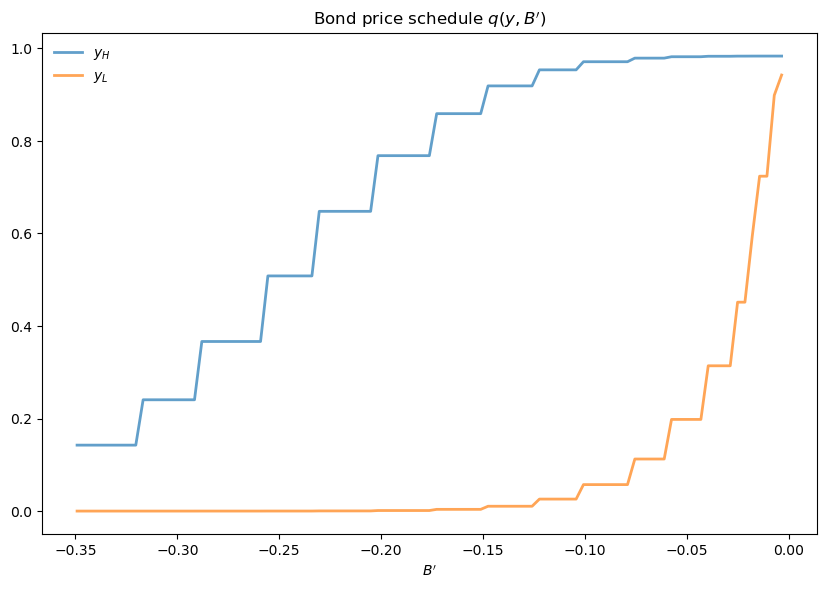

In [20]:
# Unpack some useful names
B_grid, y_grid, P = ae.B_grid, ae.y_grid, ae.P
B_size, y_size = ae.sizes()
r = ae.r

# Create "Y High" and "Y Low" values as 5% devs from mean
high, low = jnp.mean(y_grid) * 1.05, jnp.mean(y_grid) * .95
iy_high, iy_low = (jnp.searchsorted(y_grid, x) for x in (high, low))

fig, ax = plt.subplots(figsize=(10, 6.5))
ax.set_title("Bond price schedule $q(y, B')$")

# Extract a suitable plot grid
x = []
q_low = []
q_high = []
for i, B in enumerate(B_grid):
    if -0.35 <= B <= 0:  # To match fig 3 of Arellano
        x.append(B)
        q_low.append(q[i, iy_low])
        q_high.append(q[i, iy_high])
ax.plot(x, q_high, label="$y_H$", lw=2, alpha=0.7)
ax.plot(x, q_low, label="$y_L$", lw=2, alpha=0.7)
ax.set_xlabel("$B'$")
ax.legend(loc='upper left', frameon=False)
plt.show()

Draw a plot of the value functions

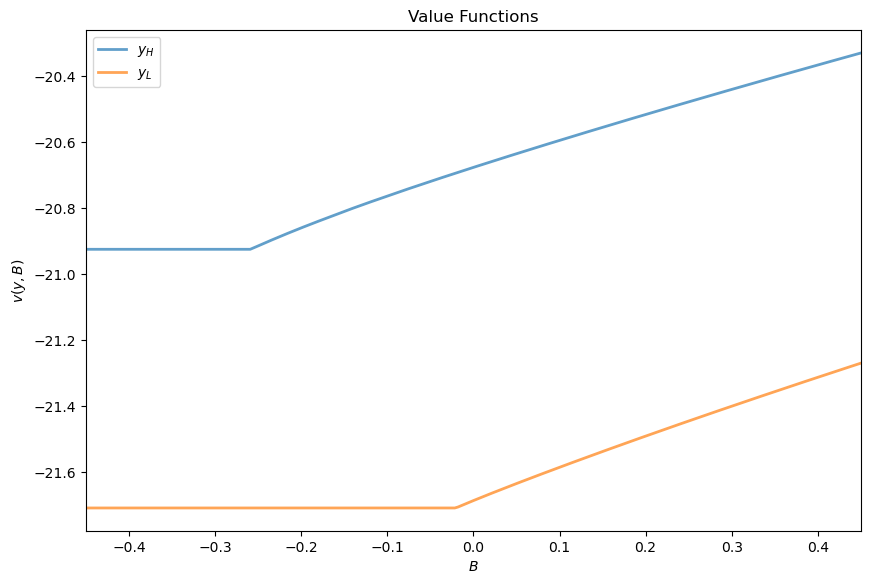

In [21]:
v = jnp.maximum(v_c, jnp.reshape(v_d, (1, y_size)))

fig, ax = plt.subplots(figsize=(10, 6.5))
ax.set_title("Value Functions")
ax.plot(B_grid, v[:, iy_high], label="$y_H$", lw=2, alpha=0.7)
ax.plot(B_grid, v[:, iy_low], label="$y_L$", lw=2, alpha=0.7)
ax.legend(loc='upper left')
ax.set(xlabel="$B$", ylabel="$v(y, B)$")
ax.set_xlim(min(B_grid), max(B_grid))
plt.show()

Draw a heat map for default probability

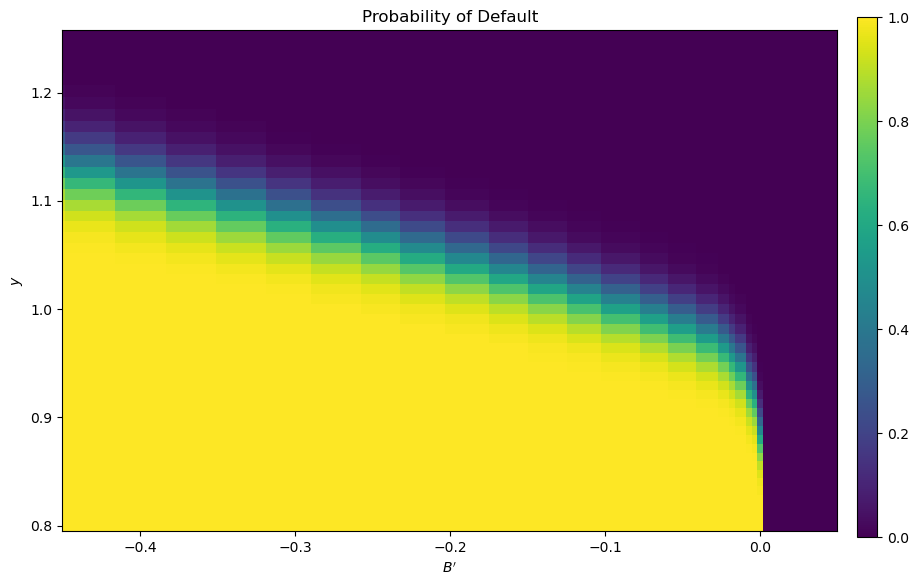

In [22]:
# Set up arrays with indices [i_B, i_y, i_yp]
shaped_v_d = jnp.reshape(v_d, (1, 1, y_size))
shaped_v_c = jnp.reshape(v_c, (B_size, 1, y_size))
shaped_P = jnp.reshape(P, (1, y_size, y_size))

# Compute delta[i_B, i_y]
default_states = 1.0 * (shaped_v_c < shaped_v_d)
delta = jnp.sum(default_states * shaped_P, axis=(2,))

# Create figure
fig, ax = plt.subplots(figsize=(10, 6.5))
hm = ax.pcolormesh(B_grid, y_grid, delta.T)
cax = fig.add_axes([.92, .1, .02, .8])
fig.colorbar(hm, cax=cax)
ax.axis([B_grid.min(), 0.05, y_grid.min(), y_grid.max()])
ax.set(xlabel="$B'$", ylabel="$y$", title="Probability of Default")
plt.show()

Plot a time series of major variables simulated from the model

In [23]:
import jax.random as random
T = 250
key = random.PRNGKey(42)
y_sim, y_a_sim, B_sim, q_sim, d_sim = simulate(ae, T, v_c, v_d, q, B_star, key)

# T = 250
# jnp.random.seed(42)
# y_sim, y_a_sim, B_sim, q_sim, d_sim = simulate(ae, T, v_c, v_d, q, B_star)

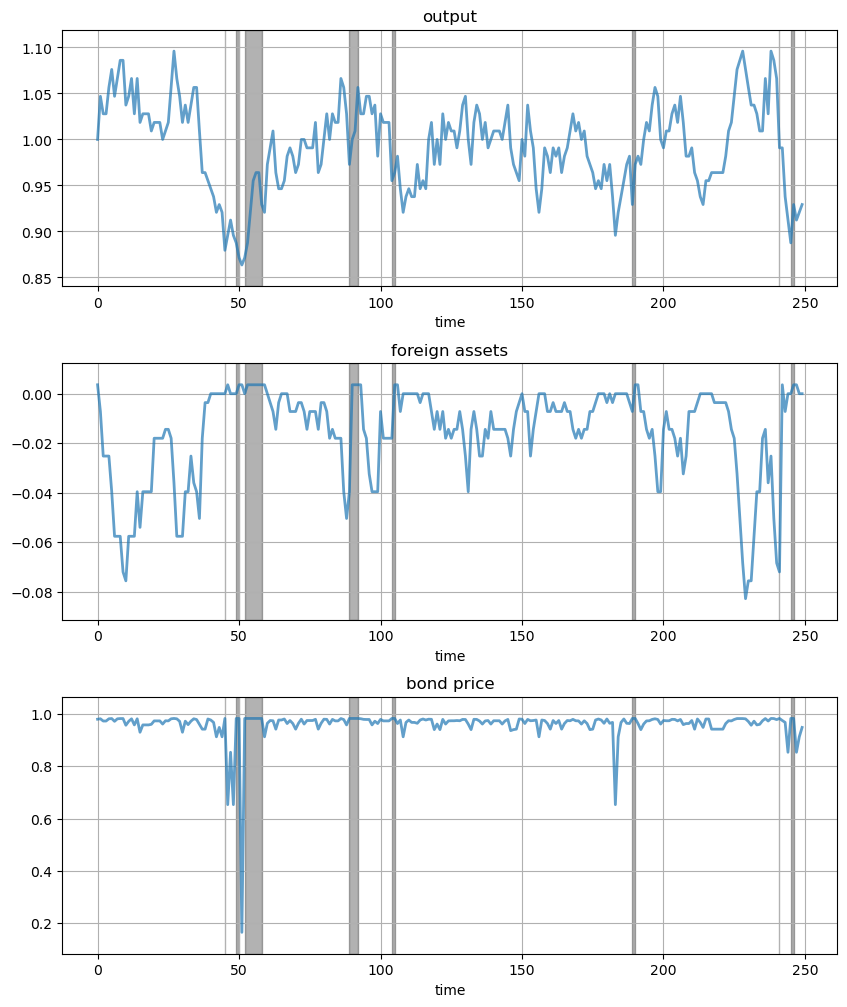

In [24]:
# Pick up default start and end dates
start_end_pairs = []
i = 0
while i < len(d_sim):
    if d_sim[i] == 0:
        i += 1
    else:
        # If we get to here we're in default
        start_default = i
        while i < len(d_sim) and d_sim[i] == 1:
            i += 1
        end_default = i - 1
        start_end_pairs.append((start_default, end_default))

plot_series = (y_sim, B_sim, q_sim)
titles = 'output', 'foreign assets', 'bond price'

fig, axes = plt.subplots(len(plot_series), 1, figsize=(10, 12))
fig.subplots_adjust(hspace=0.3)

for ax, series, title in zip(axes, plot_series, titles):
    # Determine suitable y limits
    s_max, s_min = max(series), min(series)
    s_range = s_max - s_min
    y_max = s_max + s_range * 0.1
    y_min = s_min - s_range * 0.1
    ax.set_ylim(y_min, y_max)
    for pair in start_end_pairs:
        ax.fill_between(pair, (y_min, y_min), (y_max, y_max),
                        color='k', alpha=0.3)
    ax.grid()
    ax.plot(range(T), series, lw=2, alpha=0.7)
    ax.set(title=title, xlabel="time")

plt.show()

```{solution-end}
```